In [2]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
from category_encoders import OneHotEncoder

In [3]:
data=pd.DataFrame(pd.read_json('https://api.apispreadsheets.com/api/dataset/school-grades/',orient='split'))

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

## Inżynieria cech 
### Kodowanie kategoryczne i dodanie kolumny "Czy dostał 0 pkt"

Chcąc lepiej przewidywać wyniki postanowiliśmy inaczej potraktować osoby z zerowym wynikiem. Nasz plan jest taki, aby najpierw przewidywać czy osoba dostanie 0 pkt, a następnie, jeśli z przewidywania wyjdzie że nie powinna dostać 0 pkt, przewidujemy jej wynik.

In [5]:
data['schoolsup'].describe()

count     649
unique      2
top        no
freq      581
Name: schoolsup, dtype: object

Wyrzucamy również kolumne dotyczącą edukacji ojca, gdyż z EDA wyszło nam że jest ona mocno skorelowana z edukacją matki. Postanowiliśmy wyrzucić jedną z tych cech.

In [6]:
data = data.drop(labels = "Fedu", axis = 1)
data['is_zero']=np.where(data['G3']==0,0,1)
ce_one_hot = OneHotEncoder(cols = ("Mjob", "sex", "school",'famsize',
                                   "address", "Pstatus", "reason",
                                   "guardian", "schoolsup",'famsup', 'paid',
                                   'activities', 'nursery', 'higher', 'internet', 'romantic' ))
df = ce_one_hot.fit_transform(data)

,school_1,school_2,sex_1,sex_2,age,address_1,address_2,famsize_1,famsize_2,Pstatus_1,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,is_zero
0,1,0,1,0,18,1,0,1,0,1,...,3,4,1,1,3,4,0,11,11,1
1,1,0,1,0,17,1,0,1,0,0,...,3,3,1,1,3,2,9,11,11,1
2,1,0,1,0,15,1,0,0,1,0,...,3,2,2,3,3,6,12,13,12,1
3,1,0,1,0,15,1,0,1,0,0,...,2,2,1,1,5,0,14,14,14,1
4,1,0,1,0,16,1,0,1,0,0,...,3,2,1,2,5,0,11,13,13,1


In [7]:
df=df.iloc[:,:56]

In [8]:
df

,school_1,school_2,sex_1,sex_2,age,address_1,address_2,famsize_1,famsize_2,Pstatus_1,...,internet_2,romantic_1,romantic_2,famrel,freetime,goout,Dalc,Walc,health,absences
0,1,0,1,0,18,1,0,1,0,1,...,0,1,0,4,3,4,1,1,3,4
1,1,0,1,0,17,1,0,1,0,0,...,1,1,0,5,3,3,1,1,3,2
2,1,0,1,0,15,1,0,0,1,0,...,1,1,0,4,3,2,2,3,3,6
3,1,0,1,0,15,1,0,1,0,0,...,1,0,1,3,2,2,1,1,5,0
4,1,0,1,0,16,1,0,1,0,0,...,0,1,0,4,3,2,1,2,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,0,1,1,0,19,0,1,1,0,0,...,1,1,0,5,4,2,1,2,5,4
645,0,1,1,0,18,1,0,0,1,0,...,1,1,0,4,3,4,1,1,1,4
646,0,1,1,0,18,1,0,1,0,0,...,0,1,0,1,1,1,1,1,5,6
647,0,1,0,1,17,1,0,0,1,0,...,1,1,0,2,4,5,3,4,2,6


### Grid search: "Did student get 0?"

In [9]:
 x_train, x_test, y_train, y_test = train_test_split(df, data["is_zero"],test_size=0.3, random_state=13)

In [64]:
from sklearn.linear_model import LogisticRegression

model_params={
    'random_forest':{
        'model': RandomForestClassifier(random_state=15),
        'params': {
            'n_estimators':[1,3,8,13],
            'min_samples_split': [3,5,10,20]
        }
    },
    'logistic_regession':{
        'model': LogisticRegression(random_state=15, solver='liblinear'),
        'params':{
            'C':[1,5,10],
            'penalty':['l1','l2','elasticnet']
        }
    }
}

In [65]:
results=[]
for name, param in model_params.items():
    classifier=GridSearchCV(param['model'],param['params'],cv=6,return_train_score=False)
    classifier.fit(x_train,  y_train)
    results.append({
        'model': name,
        'best_score': classifier.best_score_,
        'best_params': classifier.best_params_
    })
results

[{'model': 'random_forest',
  'best_score': 0.9757894736842107,
  'best_params': {'min_samples_split': 3, 'n_estimators': 13}},
 {'model': 'logistic_regession',
  'best_score': 0.9691812865497077,
  'best_params': {'C': 1, 'penalty': 'l1'}}]

### Main grid search

In [16]:
 x_train2, x_test2, y_train2, y_test2 = train_test_split(df, data["G3"],test_size=0.3, random_state=13)

In [17]:
model_params2={
    'random_forest':{
        'model': linear_model.LinearRegression(),
        'params': {}
    },
    'logistic_regession':{
        'model': linear_model.Lasso(random_state=15),
        'params':{
            'alpha':[0.1,1,0],
            'normalize':['True','False']
        }
    }
}

In [63]:
results2=[]

from sklearn.metrics import mean_squared_error

for name, param in model_params2.items():
    classifier=GridSearchCV(param['model'],param['params'],cv=6,return_train_score=False)
    classifier.fit(x_train2,  y_train2)
    model_performance = np.sqrt(mean_squared_error(classifier.predict(x_test2),y_test2, squared=True))
    results2.append({
        'model': name,
        'best_score': classifier.best_score_,
        'best_params': classifier.best_params_,
        'RMSE': model_performance
    })
results2                                                           

[{'model': 'random_forest',
  'best_score': 0.22534946539787493,
  'best_params': {},
  'RMSE': 2.5918186467442466},
 {'model': 'logistic_regession',
  'best_score': 0.2253926983061405,
  'best_params': {'alpha': 0, 'normalize': 'True'},
  'RMSE': 2.5932551195694638}]

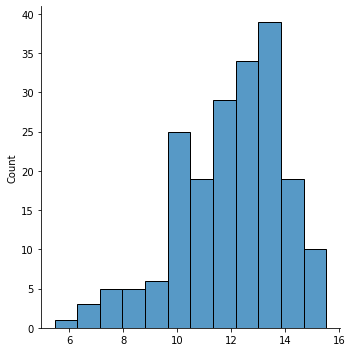

In [61]:
sns.displot(classifier.predict(x_test2))

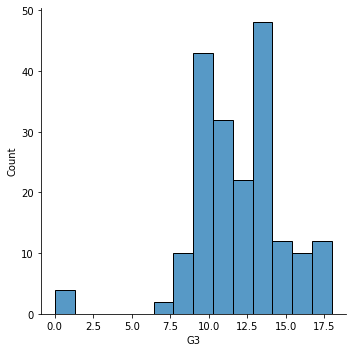

In [62]:
sns.displot(y_test2)